<b>IMPORT</b> </br>
Importing the required libraries, including tensorflow, keras, pandas, numpy and flower

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras import Model
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from tensorflow.keras.applications import DenseNet121, VGG16, ResNet50
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.activations import sigmoid, softmax
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from tensorflow.keras import backend
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
import math
import tensorflow_addons as tfa
import flwr as fl

<b>ENVIRONMENT SETTINGS</b></br>
Disabling tensorflow warnings and allowing GPU growth

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" #disabling tensorflow warnings
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true" #allowing GPU growth

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.05) #allocate memory to allow all clients to train at the same time

core_config = tf.compat.v1.ConfigProto(gpu_options = gpu_options)
core_config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=core_config)
tf.compat.v1.keras.backend.set_session(session)

<b>CLIENT SETTINGS</b></br>
Defining the number of total clients and this clients ID

In [4]:
clients = 8
client_num = 8

<b>STANDARD VALUES</b></br>
Setting the standard values for model training such as image size, batch size, epochs, validation split, etc. 

In [5]:
IMAGE_SIZE = 320 
#images are entered into the neural network with a resolution of IMAGE_SIZE x IMAGE_SIZE

CHANNELS = 3
#three channels for the pixel representation of a color image due to the use of pretrained weights (imagenet)

EPOCHS = 1
#one local epoch due to three global rounds of FedAvg

BATCH_SIZE = 16
LEARNING_RATE = 0.0001
#batch size and learning rate are similar to the official CheXpert paper

IMAGES = 191027 #number of images from the dataset used for training & validation (maximum: 191027)

TRAIN_VALIDATION_SPLIT = 0.8
#80 % of the selected images are used for training, 20% for validation

IMAGE_AUGMENTATION = True
AUGMENTATION_SPLIT = 0.5
#image agmentation is used with 50% of training images being augmented

ACTIVATION =  sigmoid
#sigmoid activatino function is used in the final dense layer for classification

INITIALIZER = GlorotUniform(seed = 42)
#weights are initialised in the first epoch using a uniform distribution

FEATURES = "Path"
#the feature column "Path" includes the image paths to be classified.

LABELS = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
#the same five labels as in the original CheXpert paper are considered: Atelectasis, Cardiomegaly, Consolidation, Edema and Pleural Effusion

U_ONES_LABELS = ["Atelectasis"]
U_ZEROS_LABELS = ["Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
#handling of the uncertainty labels: uncertain labels are mapped to one for the finding atelectasis and to zero for the other four diagnoses

METRICS = [BinaryAccuracy(name = "accuracy"), AUC(name = "auc", multi_label = True), Precision(name = "precision"), Recall(name = "recall")]
#used metrics for performance evaluation and comparison: accuracy, AUROC, precision and recall (as F1-score)

<b>FUNCTIONS</b></br>
Defining basic functions for preprocessing, reading in the images and plotting results, etc.

In [6]:
#reads in the file names of the images and converts them into same-size RGB-images with padding, thereby keeping the aspect ratio
def parse_image(features, label):
    
    image_string = tf.io.read_file(features)
    image = tf.image.decode_jpeg(image_string, channels = CHANNELS)
    image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE) #padding keeps original aspect ratio of the image
    image = tf.keras.applications.densenet.preprocess_input(image) #special preprocessing operation for the densenet structure
    
    return image, label

#creates a tensorflow dataset out of a pandas dataframe with the radiographs and selected labels
def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe[FEATURES].values, dataframe[LABELS].values))
    dataset = dataset.map(parse_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    return dataset

#preprocessing of the created dataset and image augmentation for the training data
def preprocess_dataset(dataset, is_training):
    dataset = dataset.cache().shuffle(int(len(dataset)/100), reshuffle_each_iteration = False)
    
    #augmentation for the training data, if IMAGE_AUGMENTATION is set to True
    if is_training == True and IMAGE_AUGMENTATION == True:
        print("Images in training dataset before augmentation: " + str(len(dataset)))
        dataset_augmented = dataset.take(int(AUGMENTATION_SPLIT*IMAGES*TRAIN_VALIDATION_SPLIT)).map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.concatenate(dataset_augmented)
        print("Images in training dataset after augmentation: " + str(len(dataset)))

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE) #tensorflow input pipeline: batching the dataset and prefetching for increased efficiency
    
    return dataset

#image augmentation
def augment(image, label):
    image = tfa.image.rotate(image, random.uniform(-10, 10)*math.pi/180) #rotation of the image by up to 10 degrees in both directions
    image = tf.image.central_crop(image, central_fraction = random.uniform(0.8, 1.0)) #randomly zooming into the image by up to 20 percent
    image = tf.image.random_brightness(image, max_delta = 0.1) #manipulating the brightness by up to 10 percent
    image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1) #manipulating the contrast by up to 10 percent
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]) #resizing the image due to previous central crop function
    
    return image, label

#plotting the loss and metric curves over the epochs
def plot_training(history):
    history_dict = history.history
    history_dict = list(history_dict)[:int(len(history_dict)/2)]
    
    #creating a pyplot with two columns and a fixed size
    num_rows = math.ceil(len(history_dict)/2)
    num_cols = 2
    pos = 1
    plt.figure(figsize = (13, 5*num_rows))
    
    #plotting training and validation curves for each metric and loss in one individual diagram
    for h in history_dict:
        plt.subplot(num_rows, num_cols, pos)
        plt.plot(history.history[h])
        plt.plot(history.history["val_" + h])
        plt.ylim([0.3, 0.9]) #fixing the range of the y-axis
        plt.title("model " + h, fontweight = "bold", fontsize = 13)
        plt.ylabel(h)
        plt.xlabel("epochs")
        plt.legend(["train", "valid"], loc = "best") 
        pos += 1
        
#plotting a roc curve of the model for a selected dataset (training, validation or test)
def plot_roc_curve(data):
    if data == "training":
        dataset = train_ds
        pred = pred_train
        training_str = "training"
        pos = 1
    elif data == "validation":
        dataset = valid_ds
        pred = pred_valid
        training_str = "validation"
        pos = 2
    elif data == "test":
        dataset = test_ds
        pred = pred_test
        training_str = "test"
        pos = 3
    
    #getting the labels of the dataset
    b = np.concatenate([b for a, b in dataset], axis = 0)
    
    #initialising the value of the AUC sum
    auc_sum = 0.0
    
    #calculating the true- and false-positive rate of the model predictions for every diagnosis and thereby the AUROC metric
    for l in range(len(LABELS)):
        fpr, tpr, thresholds = roc_curve(b[:,l], pred[:,l])
        auc_metric = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = LABELS[l] + " (AUC: " + str(round(auc_metric, 4)) + ")") #printing the indvidual metric values in the diagram
        auc_sum += auc_metric
        
    #creating a pyplot with a black bisector line for AUC = 0.5
    plt.plot([0, 1], [0, 1], 'k--')
    
    #defining title and axis descriptions
    plt.title("model ROC curve (" + training_str + ")", fontweight = "bold", fontsize = 13)
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.legend(loc = "best")
    
    #printing the average AUC value across all diagnoses
    auc_average = auc_sum/len(LABELS)
    print("Average AUC " + "(" + training_str + "): " + str(auc_average))
    
#plotting roc-curves for training, validation and test dataset
def plot_roc_curves():
    
    #creating a pyplot with two rows and columns
    plt.figure(figsize = (13, 10))
    num_rows = 2
    num_cols = 2
    
    plt.subplot(num_rows, num_cols, 1)
    plot_roc_curve("training") #plot training roc curve
    
    plt.subplot(num_rows, num_cols, 2)
    plot_roc_curve("validation") #plot validation roc curve
    
    plt.subplot(num_rows, num_cols, 3)
    plot_roc_curve("test") #plot test roc curve

#plotting a number of examplary images with their respective labels and neuronal network's predictions
def show_examples(data, number):
    number = min(number, 10)
    
    #selecting the right dataset
    if data == "training":
        dataset = train_ds
        pred = pred_train
    elif data == "validation":
        dataset = valid_ds
        pred = pred_valid
    elif data == "test":
        dataset = test_ds
        pred = pred_test
    
    num_rows = 1
    num_cols = 1
    pos = 1
    label_pred_str = ""

    for num in range(number): #loop for each radiograph
        
        index = random.randint(0, len(dataset)) #randomly picking rdiograph
        a, b = list(dataset.unbatch())[index] #getting the radiograph with its labels
        
        print("\033[1m" + "Image " + str(num + 1) + ":\t" + "\033[0m") #printing image umber
        
        for l in range(len(LABELS)): #printing the radiograph with its respective labels and predictions
            
            if(b[l] == 1.0):
            
                label_pred_str += str(LABELS[l] + ": ")
                label_pred_str += str(round(pred[index][l]*100, 2)) + " "
            
            print(LABELS[l])
            print(str(b.numpy()[l]) + "\t(Prediction: " + str(round(pred[index][l]*100, 2)) + "%)")
        
        fig = plt.figure(figsize = (13, 7)) #creating pyplot
        
        plt.subplot(num_rows, num_cols, pos)
        plt.imshow((a.numpy()*255).astype("uint8")) #printing radiograph
        plt.grid(None)
        plt.title("Image " + str(num + 1), fontweight = "bold", fontsize = 13)
        plt.xlabel(label_pred_str) #image subscription
        
        plt.show()
        label_pred_str = ""

<b>TRAIN & VALIDATION DATA FRAME</b></br>
Reading in the CheXpert dataset. It can be downloaded at: https://stanfordmlgroup.github.io/competitions/chexpert/
Subsequently filtering by frontal images and grouping by patient ID.

In [7]:
dataframe = pd.read_csv("Chexpert/train.csv") #reading in the dataframe via the csv-file

#setting N/A labels to zero and uncertainty labels specific to u_ones and u_zeros in the CheXpert paper
for l in LABELS:
    if (l in U_ONES_LABELS):
        dataframe[l][dataframe[l] < 0] = 1
        dataframe[l] = dataframe[l].fillna(0)
    elif (l in U_ZEROS_LABELS):
        dataframe[l][dataframe[l] < 0] = 0
        dataframe[l] = dataframe[l].fillna(0)

#filtering out lateral radiographs
dataframe = dataframe[dataframe["Frontal/Lateral"] != "Lateral"][:min(191027, IMAGES)]

#creating a patient and study column
dataframe["Patient"] = dataframe.Path.str.split('/',3,True)[2].str.split("patient", 2, True)[1] 
dataframe["Patient"] = [i.lstrip("0") for i in dataframe["Patient"]]

dataframe["Study"] = dataframe.Path.str.split('/',4,True)[3].str.split("study", 2, True)[1]

#grouping and shuffling the dataframe by patient 
patients = dataframe["Patient"].unique()
random.shuffle(patients)
dataframe = dataframe.set_index("Patient").loc[patients]
    
dataframe.head()

/scratch/slurm_tmpdir/job_20685433/ipykernel_3432329/1767291884.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[l][dataframe[l] < 0] = 1
/scratch/slurm_tmpdir/job_20685433/ipykernel_3432329/1767291884.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[l][dataframe[l] < 0] = 0


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Study
Patient,,,,,,,,,,,,,,,,,,,,
5121,Chexpert/train/patient05121/study1/view1_front...,Female,74,Frontal,PA,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1
33872,Chexpert/train/patient33872/study1/view1_front...,Female,46,Frontal,AP,1.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,1
27337,Chexpert/train/patient27337/study1/view1_front...,Female,54,Frontal,PA,1.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1
11135,Chexpert/train/patient11135/study1/view1_front...,Female,86,Frontal,AP,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1
40798,Chexpert/train/patient40798/study3/view1_front...,Male,68,Frontal,AP,NaN,-1.0,0.0,1.0,NaN,1.0,0.0,NaN,0.0,NaN,1.0,NaN,1.0,1.0,3


In [8]:
dataframe.shape #dimensions of the dataframe:

(191027, 20)

<b>SELECTING CLIENT DATA</b></br>
Sorting and selecting the data depending on the federated learning scenario

In [9]:
#Selecting the client's share of datapoints based on the total amount of data
lower_limit = int((len(dataframe)/clients)*(client_num-1))
upper_limit = int((len(dataframe)/clients)*client_num)

#printing the selected range of datapoints from the dataset
print("Dataframe taken from "+str(lower_limit)+" to "+str(upper_limit))

dataframe = dataframe[lower_limit:upper_limit]
dataframe.shape

Dataframe taken from 167148 to 191027


(23879, 20)

<b>TEST DATA FRAME</b></br>
Reading in the test dataframe of the CheXpert dataset.

In [10]:
dataframe_test = pd.read_csv("Chexpert/valid.csv") #reading in the test dataframe from the csv test file 

dataframe_test = dataframe_test[dataframe_test["Frontal/Lateral"] != "Lateral"] #filtering out the lateral radiographs

dataframe_test.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,Chexpert/valid/patient64541/study1/view1_front...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Chexpert/valid/patient64542/study1/view1_front...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Chexpert/valid/patient64543/study1/view1_front...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Chexpert/valid/patient64544/study1/view1_front...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Chexpert/valid/patient64545/study1/view1_front...,Female,55,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [11]:
dataframe_test.shape #dimensions of the test dataframe:

(202, 19)

<b>CREATE TRAIN & VALIDATION DATASET</b></br>
Creating a tf dataset

In [12]:
dataset = create_dataset(dataframe) #creating tf dataset out of the pandas dataframe

<b>SPLIT TRAIN & VALIDATION DATASET</b></br>
Splitting the dataset into training and validation

In [13]:
train_ds = dataset.take(int(TRAIN_VALIDATION_SPLIT*len(dataset))) #taking the training part of the dataset
valid_ds = dataset.skip(int(TRAIN_VALIDATION_SPLIT*len(dataset))) #taking the validation part of the dataset

train_ds = preprocess_dataset(train_ds, True) #preprocessing with augmentation
valid_ds = preprocess_dataset(valid_ds, False) #preprocessing without augmentation

Images in training dataset before augmentation: 19103
Images in training dataset after augmentation: 38206


<b>CREATE TEST DATASET</b></br>
Creating the test dataset

In [14]:
test_ds = create_dataset(dataframe_test) #creating the test dataset
test_ds = preprocess_dataset(test_ds, False) #preprocessing without augmentation

<b>MODEL</b></br>Creating CNN structure for image classification

In [15]:
strategy = tf.distribute.MirroredStrategy() #distributed strategy for optimal GPU  distribution
with strategy.scope():

    #creating the base model
    base_model = DenseNet121(
        include_top = False, #no default final classification layer
        weights = "imagenet", #Transfer learning with pretrained weights
        input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
        pooling = None, #no pooling 
    )

    base_model.trainable = True #allow base model weight training

    inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) #model input shape

    #adding the different layers
    x = base_model(inputs, training = True) #base model
    x = tf.keras.layers.Conv2D(64, (3, 3))(x) #further convolutional layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x) #pooling layer
    x = tf.keras.layers.BatchNormalization()(x) #batchNorm layer
    x = tf.keras.layers.Dropout(0.4)(x) #dropout layer

    #final dense layer for classification
    outputs = tf.keras.layers.Dense(
        len(LABELS), #number of nodes equals the number of classes
        kernel_initializer = INITIALIZER, #initialising model weights with specific distribution
        activation = ACTIVATION #setting activation function
    )(x) 

    model = tf.keras.Model(inputs, outputs)

    #compiling the model
    model.compile(
        loss = "binary_crossentropy", #model loss definition
        optimizer = Adam(learning_rate = LEARNING_RATE), #setting optimizer to Adam with fixed learning rate
        metrics = [BinaryAccuracy(name = "accuracy"), AUC(name = "auc", multi_label = True), Precision(name = "precision"), Recall(name = "recall")] #selecting predifined metrics
    )

    model.summary(expand_nested = False) #printing model summary

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

<b>TRAINING</b></br>
Defining FL client and training the model

In [16]:
class Client(fl.client.NumPyClient): #defining FL client
    def get_parameters(self):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        history = model.fit(train_ds, epochs = EPOCHS, validation_data = valid_ds)
        return model.get_weights(), len(train_ds), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy, auc, precision, recall = model.evaluate(train_ds)
        return loss, len(train_ds), {}

    
fl.client.start_numpy_client("localhost:8080", client = Client()) #start training

INFO flower 2022-05-04 08:49:18,539 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-05-04 08:49:18,540 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-05-04 08:49:18,541 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-05-04 08:49:18,542 | connection.py:39 | ChannelConnectivity.READY


INFO:tensorflow:batch_all_reduce: 368 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 368 all-reduces with algorithm = nccl, num_packs = 1
2388/2388 [==============================] - 495s 207ms/step - loss: 0.4200 - accuracy: 0.8060 - auc: 0.7492 - precision: 0.6659 - recall: 0.3071


DEBUG flower 2022-05-04 10:26:07,186 | connection.py:121 | gRPC channel closed
INFO flower 2022-05-04 10:26:07,188 | app.py:101 | Disconnect and shut down


<b>MODEL EVALUATION ON TEST DATASET</b>

In [17]:
model.evaluate(test_ds) #evaluating model performance on the test dataset

13/13 [==============================] - 6s 453ms/step - loss: 0.5146 - accuracy: 0.7614 - auc: 0.8177 - precision: 0.6900 - recall: 0.2473


[0.5145907402038574,
 0.7613861560821533,
 0.8177270889282227,
 0.6899999976158142,
 0.24731183052062988]

<b>MODEL PREDICTIONS</b></br>
Generating model predictions

In [18]:
pred_train = model.predict(train_ds)
pred_valid = model.predict(valid_ds)
pred_test = model.predict(test_ds)

<b>PLOT ROC CURVES</b></br>
Plotting roc curves for training, validation and test datasets

Average AUC (training): 0.7494337994897794
Average AUC (validation): 0.7358547119904881
Average AUC (test): 0.81722206691257


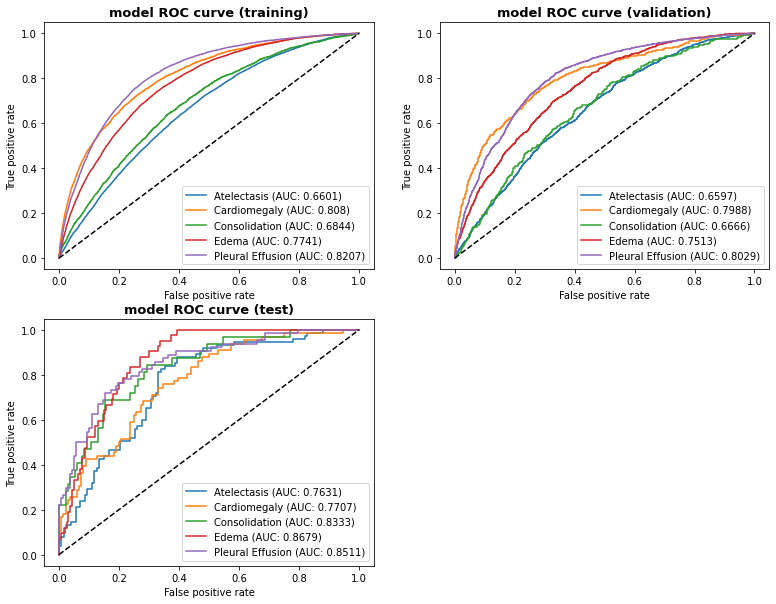

In [19]:
plot_roc_curves()